In [1]:
# !set CUDA_VISIBLE_DEVICES=""
# !set CUDA_LAUNCH_BLOCKING=1

In [1]:
import pandas as pd
import sklearn
import os
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from torch.utils.data import DataLoader
os.environ["KERAS_BACKEND"] = 'torch'
# os.environ["CUDA_VISIBLE_DEVICES"] = "" 
import keras

In [2]:
# torch.backends.cudnn.enabled = False
# torch.cuda.is_available = lambda: False
# torch.device("cpu")

device(type='cpu')

In [2]:
torch.cuda.is_available()

True

In [3]:
df = pd.read_csv('pmi-data.csv')
df = df.loc[df['split'] == 'train']

In [4]:
%%html
<h1>1. Datasets and Dataloaders</h1>

In [4]:
train_data, valid_data = sklearn.model_selection.train_test_split(df, test_size=0.25, shuffle=True, random_state=120)

In [5]:
minmax_scaler = sklearn.preprocessing.MinMaxScaler()
train_data[['age', 'avg_glucose_level', 'bmi']] = minmax_scaler.fit_transform(train_data[['age', 'avg_glucose_level', 'bmi']])
valid_data[['age', 'avg_glucose_level', 'bmi']] = minmax_scaler.transform(valid_data[['age', 'avg_glucose_level', 'bmi']])

In [6]:
train_data

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,split
2082,60586,1,0.805556,0,0,1,4,1,0.139276,0.153846,1,0,train
2267,28027,1,0.444444,0,0,1,2,0,0.131936,0.069100,2,0,train
2902,59272,2,0.388889,0,0,1,4,1,0.111255,0.254237,0,0,train
1666,10649,1,1.000000,0,0,1,4,0,0.114856,0.238592,2,0,train
899,39823,1,0.430556,0,0,1,2,1,0.806666,0.259452,0,0,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,19101,1,0.083333,0,0,0,4,0,0.151694,0.092568,2,0,train
12,58202,1,0.555556,1,0,1,3,1,0.518373,0.203390,2,1,train
940,321,1,0.958333,0,0,0,3,1,0.077832,0.275098,2,0,train
1495,1679,2,0.347222,0,0,1,4,1,0.103222,0.179922,1,0,train


In [7]:
class StrokeDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.labels = data['stroke']
        self.samples = data.drop(columns=['stroke', 'id', 'split'])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):        
        return torch.Tensor(self.samples.iloc[0].values), torch.tensor(self.labels.iloc[idx])

In [8]:
train_dataloader = DataLoader(StrokeDataset(train_data), batch_size=16, shuffle=True)
valid_dataloader = DataLoader(StrokeDataset(valid_data))

In [9]:
%%html
<h3>I think shuffling is a good idea because if we take a look at the pmi-data.csv we can see that all the cases with stroke=1 come first in the csv so that means if we didnt shuffle, all of them would be chosen for the training and none would be left for the testing</h3>

In [10]:
%%html
<h1>2. Model</h1>

In [62]:
import torch.nn.functional as F
class Model(torch.nn.Module):
    def __init__(self, in_size, out_size):
        super().__init__()
        self.l1 = torch.nn.Linear(in_size, 8)
        self.l2 = torch.nn.Linear(8, 8)
        # self.l3 = torch.nn.Linear(16, 8)
        # self.l4 = torch.nn.Linear(8, 8)
        # self.l5 = torch.nn.Linear(8, 8)
        # self.l6 = torch.nn.Linear(8, 8)
        # self.l7 = torch.nn.Linear(8, 8)
        # self.l8 = torch.nn.Linear(8, 16)
        # self.l9 = torch.nn.Linear(16, 16)
        # self.l10 = torch.nn.Linear(16, 16)
        # self.l11 = torch.nn.Linear(16, 8)
        self.l12 = torch.nn.Linear(8, out_size)

        torch.nn.init.xavier_uniform_(self.l1.weight)
        torch.nn.init.xavier_uniform_(self.l2.weight)
        # torch.nn.init.xavier_uniform_(self.l3.weight)
        # torch.nn.init.xavier_uniform_(self.l4.weight)
        # torch.nn.init.xavier_uniform_(self.l5.weight)
        # torch.nn.init.xavier_uniform_(self.l6.weight)
        # torch.nn.init.xavier_uniform_(self.l7.weight)
        # torch.nn.init.xavier_uniform_(self.l8.weight)
        # torch.nn.init.xavier_uniform_(self.l9.weight)
        # torch.nn.init.xavier_uniform_(self.l10.weight)
        # torch.nn.init.xavier_uniform_(self.l11.weight)
        torch.nn.init.xavier_uniform_(self.l12.weight)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        # x = F.relu(self.l3(x))
        # x = F.relu(self.l4(x))
        # x = F.relu(self.l5(x))
        # x = F.relu(self.l6(x))
        # x = F.relu(self.l7(x))
        # x = F.relu(self.l8(x))
        # x = F.relu(self.l9(x))
        # x = F.relu(self.l10(x))
        # x = F.relu(self.l11(x))
        x = self.l12(x)
        return x.squeeze()

def get_y_pred_y_true_valid_loss(model, threshold = 0.5):
    y_pred = []
    y_true = []
    valid_loss = 0
    with torch.no_grad():
        for i, data in enumerate(valid_dataloader, 0):
            features, labels = data
            y_true.append(labels[0])
            outputs = model.forward(features)

            loss = loss_fn(outputs, labels[0].float())
            valid_loss += loss.item()
            y_pred.append((torch.sigmoid(outputs) > threshold).int())
    return y_pred, y_true, valid_loss

In [39]:
model = Model(10, 1)

In [13]:
# for param in model.parameters():
#     print(param)

In [79]:
%%html
<h1>3. Optimizer and Loss function</h1>

In [14]:
optimizer = torch.optim.Adam(model.parameters())
loss_fn = torch.nn.BCEWithLogitsLoss()

In [15]:
%%html
<h1>4. Training </h1>

In [16]:
N_EPOCHS = 30

best_acc = 0

hist_train_loss = []
hist_valid_loss = []
hist_accuracy = []

for epoch in range(N_EPOCHS):
    train_loss = 0
    valid_loss = 0
    for i, data in enumerate(train_dataloader, 0):
        features, labels = data
        
        optimizer.zero_grad()

        outputs = model(features).squeeze()
        #y_true = torch.tensor(labels).to(torch.float)
        loss = loss_fn(outputs, labels.float())
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    y_pred, y_true, valid_loss = get_y_pred_y_true_valid_loss(model)

    accuracy = sklearn.metrics.accuracy_score(y_true, y_pred)
    print(f'Epoch {epoch}, accuracy: {accuracy}, train_loss={train_loss / len(train_dataloader)}, valid_loss={valid_loss / len(valid_dataloader)}')
    if accuracy > best_acc:
        torch.save(model.state_dict(), 'best_unbalanced_accuracy')
        best_acc = accuracy

    hist_train_loss.append(train_loss)
    hist_valid_loss.append(valid_loss)
    hist_accuracy.append(accuracy)

Epoch 0, accuracy: 0.9565217391304348, train_loss=0.3411521362279778, valid_loss=0.1876725424890933
Epoch 1, accuracy: 0.9565217391304348, train_loss=0.22054793218623348, valid_loss=0.19919706427532693
Epoch 2, accuracy: 0.9565217391304348, train_loss=0.2188610520158241, valid_loss=0.20929445391115936
Epoch 3, accuracy: 0.9565217391304348, train_loss=0.22046512354220918, valid_loss=0.19020257825436798
Epoch 4, accuracy: 0.9565217391304348, train_loss=0.21909734940350944, valid_loss=0.1899769513503365
Epoch 5, accuracy: 0.9565217391304348, train_loss=0.21874063840108132, valid_loss=0.20261729281881583
Epoch 6, accuracy: 0.9565217391304348, train_loss=0.21905783141282067, valid_loss=0.18697687853937564
Epoch 7, accuracy: 0.9565217391304348, train_loss=0.21936766447415992, valid_loss=0.19692585779272992
Epoch 8, accuracy: 0.9565217391304348, train_loss=0.2206880160009683, valid_loss=0.19467556994894278
Epoch 9, accuracy: 0.9565217391304348, train_loss=0.21890028365957204, valid_loss=0.190

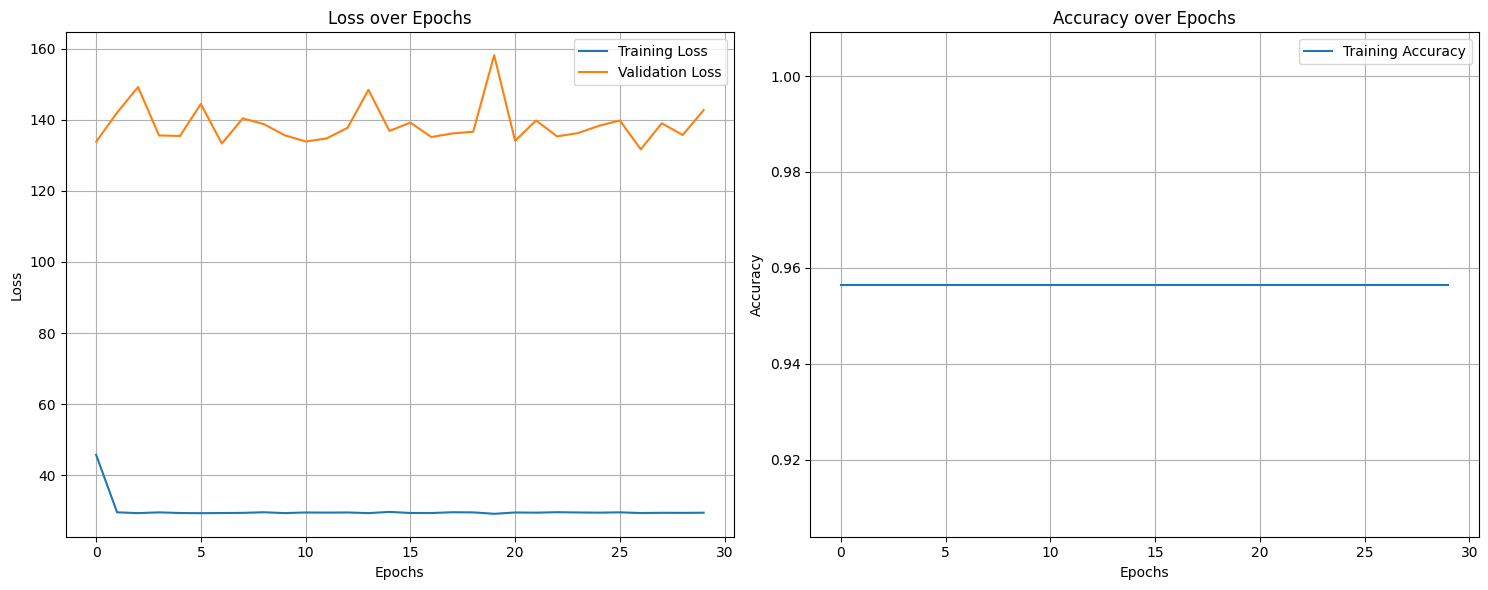

In [17]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(hist_train_loss, label='Training Loss')
plt.plot(hist_valid_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(hist_accuracy, label='Training Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [278]:
%%html
<h1>5. Evaluation</h1>

In [18]:
model.load_state_dict(torch.load('best_unbalanced_accuracy'))
y_pred, y_true, _ = get_y_pred_y_true_valid_loss(model)

Precision: 0.0
Recall: 0.0
F1_score: 0.0


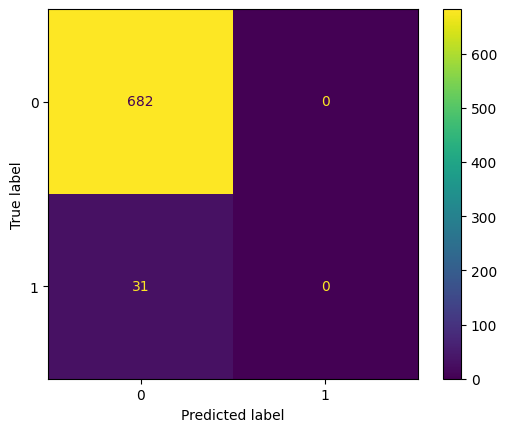

In [19]:
conf_matrix = sklearn.metrics.confusion_matrix(y_true, y_pred)
precision = sklearn.metrics.precision_score(y_true, y_pred, zero_division=0)
recall = sklearn.metrics.recall_score(y_true, y_pred,zero_division=0)
f1_score = sklearn.metrics.f1_score(y_true, y_pred,zero_division=0)
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1_score: {f1_score}')
sklearn.metrics.ConfusionMatrixDisplay(conf_matrix).plot()

In [86]:
%%html
<h1>6. Balance the training data distribution</h1>

In [71]:
model = Model(10, 1)
pos_weight = torch.tensor(train_data['stroke'].loc[train_data.stroke == 0].count() / train_data['stroke'].loc[train_data.stroke == 1].count())
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

In [32]:
pos_weight

tensor(16.5328, dtype=torch.float64)

In [64]:
# Should reach <0.5 loss on 10 samples
x_tiny, y_tiny = next(iter(train_dataloader))
x_tiny = x_tiny[:2]
y_tiny = y_tiny[:2]
print(x_tiny.shape)
for _ in range(3000):
    optimizer.zero_grad()
    loss = loss_fn(model(x_tiny), y_tiny.float())
    loss.backward()
    optimizer.step()
print("Overfit test loss:", loss.item())

torch.Size([2, 10])
Overfit test loss: 0.09380269050598145


In [72]:
N_EPOCHS = 30

best_f1_score = -1

hist_train_loss = []
hist_valid_loss = []

hist_accuracy = []
hist_precision = []
hist_recall = []
hist_f1_score = []

for epoch in range(N_EPOCHS):
    train_loss = 0
    valid_loss = 0

    for i, data in enumerate(train_dataloader, 0):
        features, labels = data
        
        optimizer.zero_grad()

        outputs = model(features).squeeze()
        #y_true = torch.tensor(labels).to(torch.float)
        loss = loss_fn(outputs, labels.float())
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

        # total_grad = 0
        # for p in model.parameters():
        #     if p.grad is not None:
        #         total_grad += p.grad.norm().item()
        # if total_grad < 0.1:
        #     print('vanishing gradient')
        # if total_grad > 1000:
        #     print('exploding gradient')
    
        # for name, param in model.named_parameters():
        #     print(param.grad)
    
    y_pred, y_true, valid_loss = get_y_pred_y_true_valid_loss(model)

    accuracy = sklearn.metrics.accuracy_score(y_true, y_pred)
    f1_score = sklearn.metrics.f1_score(y_true, y_pred, zero_division=0)
    recall = sklearn.metrics.recall_score(y_true, y_pred, zero_division=0)
    precision = sklearn.metrics.precision_score(y_true, y_pred, zero_division=0)

    hist_f1_score.append(f1_score)
    hist_recall.append(recall)
    hist_precision.append(precision)
    
    print(f'Epoch {epoch}, accuracy: {accuracy}, train_loss={train_loss / len(train_dataloader)}, valid_loss={valid_loss / len(valid_dataloader)}, f1_score={f1_score}, recall={recall}, precision={precision}, {"*" if (f1_score > best_f1_score) else None}')
    if f1_score > best_f1_score:
        torch.save(model.state_dict(), 'best_balanced_f1')
        best_f1_score = f1_score

    hist_train_loss.append(train_loss / len(train_dataloader))
    hist_valid_loss.append(valid_loss / len(valid_dataloader))
    hist_accuracy.append(accuracy)

Epoch 0, accuracy: 0.9565217391304348, train_loss=2.567739305211537, valid_loss=1.8643287990404211, f1_score=0.0, recall=0.0, precision=0.0, *
Epoch 1, accuracy: 0.9565217391304348, train_loss=2.3587017859985577, valid_loss=1.7550021876459536, f1_score=0.0, recall=0.0, precision=0.0, None
Epoch 2, accuracy: 0.9565217391304348, train_loss=2.1712034922927175, valid_loss=1.658419422481371, f1_score=0.0, recall=0.0, precision=0.0, None
Epoch 3, accuracy: 0.9565217391304348, train_loss=2.019740351990088, valid_loss=1.5756007692088252, f1_score=0.0, recall=0.0, precision=0.0, None
Epoch 4, accuracy: 0.9565217391304348, train_loss=1.8985463411950354, valid_loss=1.5044195237367048, f1_score=0.0, recall=0.0, precision=0.0, None
Epoch 5, accuracy: 0.9565217391304348, train_loss=1.7915349442567399, valid_loss=1.4466051537057627, f1_score=0.0, recall=0.0, precision=0.0, None
Epoch 6, accuracy: 0.9565217391304348, train_loss=1.7176050072285667, valid_loss=1.3950771767160166, f1_score=0.0, recall=0.

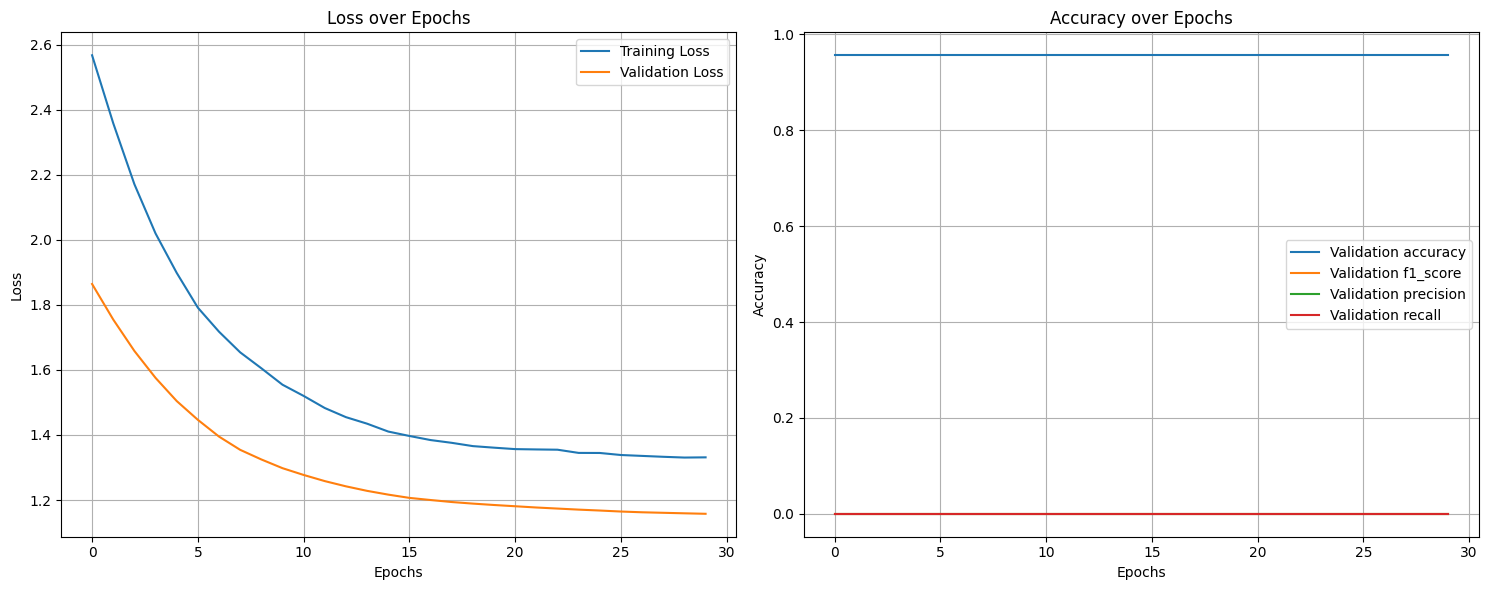

In [73]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(hist_train_loss, label='Training Loss')
plt.plot(hist_valid_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(hist_accuracy, label='Validation accuracy')
plt.plot(hist_f1_score, label='Validation f1_score')
plt.plot(hist_precision, label='Validation precision')
plt.plot(hist_recall, label='Validation recall')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Precision: 0.0
Recall: 0.0
F1_score: 0.0


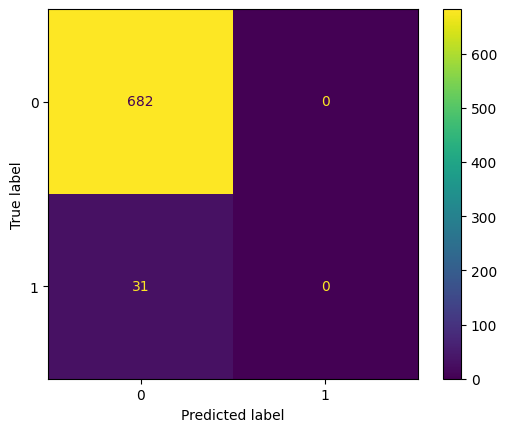

In [74]:
model.load_state_dict(torch.load('best_balanced_f1'))
y_pred, y_true, _ = get_y_pred_y_true_valid_loss(model)
        
conf_matrix = sklearn.metrics.confusion_matrix(y_true, y_pred)
precision = sklearn.metrics.precision_score(y_true, y_pred, zero_division=0)
recall = sklearn.metrics.recall_score(y_true, y_pred)
f1_score = sklearn.metrics.f1_score(y_true, y_pred)
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1_score: {f1_score}')
sklearn.metrics.ConfusionMatrixDisplay(conf_matrix).plot()

In [288]:
%%html
<h1>7. Focal Loss</h1>

In [289]:
class BinaryFocalLoss(torch.nn.Module):
    def __init__(self, alpha=0.25, gamma=2, reduction='mean'):
        super(BinaryFocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.bce = torch.nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, inputs, targets):
        BCE_loss = self.bce(inputs, targets)
        pt = torch.exp(-BCE_loss)  # pt = p if target=1, else 1-p
        alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
        F_loss = alpha_t * (1 - pt)**self.gamma * BCE_loss
        
        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss

In [290]:
model = Model(10, 1)
optimizer = torch.optim.Adam(model.parameters())
loss_fn = BinaryFocalLoss(alpha=0.7, gamma=2)

In [ ]:
N_EPOCHS = 30

best_f1_score = 0

hist_train_loss = []
hist_valid_loss = []

hist_accuracy = []
hist_precision = []
hist_recall = []
hist_f1_score = []

for epoch in range(N_EPOCHS):
    train_loss = 0
    valid_loss = 0
    
    for i, data in enumerate(train_dataloader, 0):
        features, labels = data
        
        optimizer.zero_grad()

        outputs = model(features).squeeze()
        #y_true = torch.tensor(labels).to(torch.float)
        loss = loss_fn(outputs, labels.float())
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    y_pred, y_true, _ = get_y_pred_y_true_valid_loss(model)

    accuracy = sklearn.metrics.accuracy_score(y_true, y_pred)
    f1_score = sklearn.metrics.f1_score(y_true, y_pred, zero_division=0)
    recall = sklearn.metrics.recall_score(y_true, y_pred, zero_division=0)
    precision = sklearn.metrics.precision_score(y_true, y_pred, zero_division=0)

    hist_f1_score.append(f1_score)
    hist_recall.append(recall)
    hist_precision.append(precision)
    
    print(f'Epoch {epoch}, accuracy: {accuracy}, train_loss={train_loss / len(train_dataloader)}, valid_loss={valid_loss / len(valid_dataloader)}, f1_score={f1_score}, recall={recall}, precision={precision}, {"*" if (f1_score > best_f1_score) else None}')
    if f1_score > best_f1_score:
        torch.save(model.state_dict(), 'best_balanced_f1_focal_loss')
        best_f1_score = f1_score

    hist_train_loss.append(train_loss)
    hist_valid_loss.append(valid_loss)
    hist_accuracy.append(accuracy)

C:\Users\Fabi\AppData\Local\Temp\ipykernel_25140\1604072130.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_balanced_f1_focal_loss

Precision: 0.043478260869565216
Recall: 1.0
F1_score: 0.08333333333333333


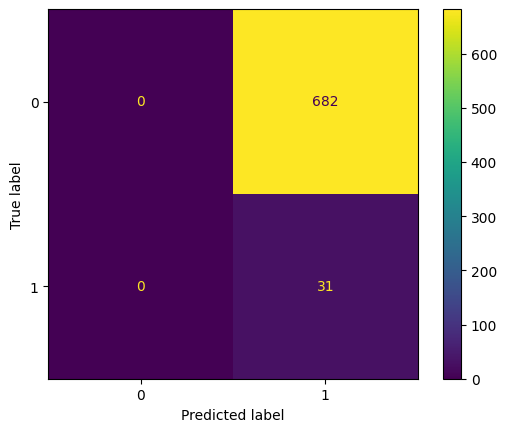

In [26]:
model =  Model(10, 1)
model.load_state_dict(torch.load('best_balanced_f1_focal_loss'))
y_pred, y_true, _ = get_y_pred_y_true_valid_loss(model)
        
conf_matrix = sklearn.metrics.confusion_matrix(y_true, y_pred)
precision = sklearn.metrics.precision_score(y_true, y_pred, zero_division=0)
recall = sklearn.metrics.recall_score(y_true, y_pred)
f1_score = sklearn.metrics.f1_score(y_true, y_pred)
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1_score: {f1_score}')
sklearn.metrics.ConfusionMatrixDisplay(conf_matrix).plot()

In [293]:
%%html
<h1>8. Inspecting model outputs. NOT DONE YET</h1>

In [27]:
model_unbalanced_accuracy = Model(10, 1)
model_unbalanced_accuracy.load_state_dict(torch.load('best_unbalanced_accuracy'))

model_balanced_f1 = Model(10, 1)
model_balanced_f1.load_state_dict(torch.load('best_balanced_f1'))

model_balanced_f1_focal = Model(10, 1)
model_balanced_f1_focal.load_state_dict(torch.load('best_balanced_f1_focal_loss'))

C:\Users\Fabi\AppData\Local\Temp\ipykernel_25140\1535333809.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_unbalanced_accuracy.load_state_dict(torch.load('best_un

<All keys matched successfully>

In [296]:
def probabilities(model):
    probs = []
    with torch.no_grad():
        for data, label in valid_dataloader:
            if label == 0:
                continue
            logits = model(data)
            probs.append(torch.sigmoid(logits))        
    return np.array(probs)

vals_model_unbalanced_accuracy = probabilities(model_unbalanced_accuracy)[0]
vals_model_balanced_f1 = probabilities(model_balanced_f1)[0]
vals_model_f1_focal = probabilities(model_balanced_f1_focal)[0]

TypeError: object of type 'numpy.float32' has no len()

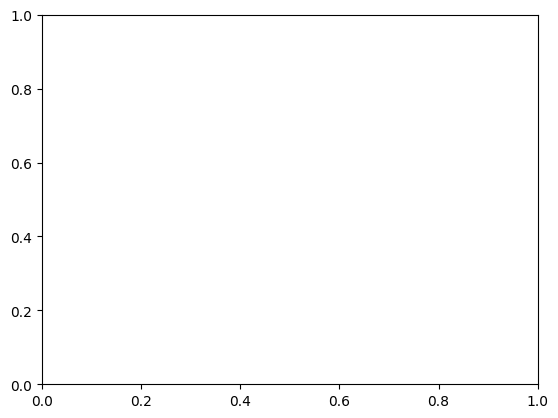

In [297]:
fig, ax = plt.subplots()

N = len(vals_model_unbalanced_accuracy)
x = np.arange(N)  # x-axis positions
width = 0.25  # Width of each bar

# Plot each set of bars with adjusted positions
ax.bar(x - width, vals_model_unbalanced_accuracy, width,
       edgecolor='white', linewidth=0.7, label='Unbalanced Accuracy')
ax.bar(x, vals_model_balanced_f1, width,
       edgecolor='white', linewidth=0.7, label='Balanced F1')
ax.bar(x + width, vals_model_f1_focal, width,
       edgecolor='white', linewidth=0.7, label='F1 Focal')

# Configure axes and labels
ax.set(
    xticks=x,  # All values in the list (indices)
    ylim=(0, 1),
    yticks=np.linspace(0, 1, 11)  # Ticks every 0.1
)
ax.legend()

plt.show()

In [298]:
%%html
<h1>9. Beyond default thresholds</h1>

In [31]:
def get_f1_score_models(threshold):
    f1_scores_model_unbalanced_accuracy = None
    f1_scores_model_balanced_f1 = None
    f1_scores_model_balanced_f1_focal = None

    y_pred_model_unbalanced_accuracy = []
    y_pred_model_balanced_f1 = []
    y_pred_model_balanced_f1_focal = []
    y_true = []
    
    y_pred_model_unbalanced_accuracy, y_true_1, _ = get_y_pred_y_true_valid_loss(model_unbalanced_accuracy, threshold)
    y_pred_model_balanced_f1, y_true_2, _ = get_y_pred_y_true_valid_loss(model_balanced_f1, threshold)
    y_pred_model_balanced_f1_focal, y_true_3, _ = get_y_pred_y_true_valid_loss(model_balanced_f1_focal, threshold)

    f1_scores_model_unbalanced_accuracy = sklearn.metrics.f1_score(y_true_1, y_pred_model_unbalanced_accuracy)
    f1_scores_model_balanced_f1 = sklearn.metrics.f1_score(y_true_2, y_pred_model_balanced_f1)
    f1_scores_model_balanced_f1_focal = sklearn.metrics.f1_score(y_true_3, y_pred_model_balanced_f1_focal)

    return f1_scores_model_unbalanced_accuracy, f1_scores_model_balanced_f1, f1_scores_model_balanced_f1_focal

In [52]:
history_thresholds = []
maximum = 0
for threshold in np.arange(0.25, 0.76, 0.01):
    history_thresholds.append(get_f1_score_models(threshold))
    maximum = max(maximum, max(history_thresholds[-1]))

In [61]:
%%html
<h1>10. Threshold sensitivity</h1>

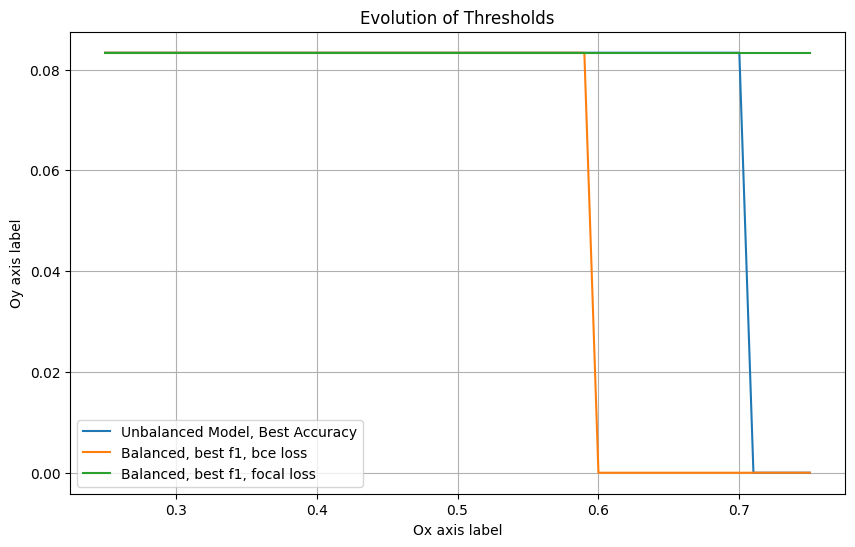

In [60]:
x = np.arange(0.25, 0.76, 0.01)

a = [t[0] for t in history_thresholds]
b = [t[1] for t in history_thresholds]
c = [t[2] for t in history_thresholds]

plt.figure(figsize=(10, 6))
plt.plot(x, a, label='Unbalanced Model, Best Accuracy')
plt.plot(x, b, label='Balanced, best f1, bce loss')
plt.plot(x, c, label='Balanced, best f1, focal loss')

plt.xlabel('Ox axis label')
plt.ylabel('Oy axis label')
plt.title('Evolution of Thresholds')
plt.legend()
plt.grid(True)
plt.show()